In [1]:
import time
import os
import random
import numpy as np                                                
import matplotlib.pyplot as plt                                   
import autograd, autograd.core, autograd.extend, autograd.tracer  
import autograd.numpy as anp      
import scipy, scipy.ndimage, scipy.sparse, scipy.sparse.linalg    
                                                     
import gym
# from gym import spaces
from gymnasium import spaces
import gymnasium 

from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import results_plotter

In [2]:
# !pip3 install --upgrade stable_baselines3
# !pip3 install gym==0.22.0 

The below code is my RL extension to and rework of https://www.researchgate.net/publication/360698153_A_Tutorial_on_Structural_Optimization 
and
https://www.sciencedirect.com/science/article/pii/S0264127522002933

In [3]:
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
    
def get_args(normals, forces, density=1e-4):  # Manage the problem setup parameters
    width = normals.shape[0] - 1
    height = normals.shape[1] - 1
    fixdofs = np.flatnonzero(normals.ravel())
    alldofs = np.arange(2 * (width + 1) * (height + 1))
    freedofs = np.sort(list(set(alldofs) - set(fixdofs)))
    params = {
      # material properties
      'young': 1, 'young_min': 1e-9, 'poisson': 0.3, 'g': 0,
      # constraints
      'density': density, 'xmin': 0.001, 'xmax': 1.0,
      # input parameters
      'nelx': width, 'nely': height, 'mask': 1, 'penal': 3.0, 'filter_width': 1,
      'freedofs': freedofs, 'fixdofs': fixdofs, 'forces': forces.ravel(),
      # optimization parameters
      'opt_steps': 80, 'print_every': 10}
    return ObjectView(params)

def mbb_beam(width=7, height=7, density=1e-4, y=1, x=0, rd=-1):  # textbook beam example
    normals = np.zeros((width + 1, height + 1, 2))
    normals[0, 0, x] = 1
    normals[0, 0, y] = 1
    normals[0, -1, x] = 1
    normals[0, -1, y] = 1
    forces = np.zeros((width + 1, height + 1, 2))
    forces[-1, rd, y] = -1
    return normals, forces, density

In [4]:
def young_modulus(x, e_0, e_min, p=3):
    return e_min + x ** p * (e_0 - e_min)

def physical_density(x, args, volume_contraint=False, use_filter=True):
    x = args.mask * x.reshape(args.nely, args.nelx)  # reshape from 1D to 2D
    return gaussian_filter(x, args.filter_width) if use_filter else x  # maybe filter

def mean_density(x, args, volume_contraint=False, use_filter=True):
    return anp.mean(physical_density(x, args, volume_contraint, use_filter)) / anp.mean(args.mask)

In [5]:
def objective(x, args, volume_contraint=False, use_filter=True):
    kwargs = dict(penal=args.penal, e_min=args.young_min, e_0=args.young)
    x_phys = physical_density(x, args, volume_contraint=volume_contraint, use_filter=use_filter)
    ke     = get_stiffness_matrix(args.young, args.poisson)  # stiffness matrix
    u      = displace(x_phys, ke, args.forces, args.freedofs, args.fixdofs, **kwargs)
    c      = compliance(x_phys, u, ke, **kwargs)
    return c

In [6]:
# @autograd.extend.primitive
def gaussian_filter(x, width): # 2D gaussian blur/filter
    return scipy.ndimage.gaussian_filter(x, width, mode='reflect')

def _gaussian_filter_vjp(ans, x, width): # gives the gradient of orig. function w.r.t. x
    del ans, x  # unused
    return lambda g: gaussian_filter(g, width)
# autograd.extend.defvjp(gaussian_filter, _gaussian_filter_vjp)

In [7]:
def compliance(x_phys, u, ke, *, penal=3, e_min=1e-9, e_0=1):
    nely, nelx = x_phys.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords for the index map

    n1 = (nely+1)*(elx+0) + (ely+0)  # nodes
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    all_ixs = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    u_selected = u[all_ixs]  # select from u matrix

    ke_u = anp.einsum('ij,jkl->ikl', ke, u_selected)  # compute x^penal * U.T @ ke @ U
    ce = anp.einsum('ijk,ijk->jk', u_selected, ke_u)
    C = young_modulus(x_phys, e_0, e_min, p=penal) * ce.T
    return anp.sum(C)

def get_stiffness_matrix(e, nu):  # e=young's modulus, nu=poisson coefficient
    k = anp.array([1/2-nu/6, 1/8+nu/8, -1/4-nu/12, -1/8+3*nu/8,
                -1/4+nu/12, -1/8-nu/8, nu/6, 1/8-3*nu/8])
    return e/(1-nu**2)*anp.array([[k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]],
                               [k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
                               [k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
                               [k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
                               [k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
                               [k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
                               [k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
                               [k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]]])

In [8]:
def get_k(stiffness, ke):
    # Constructs sparse stiffness matrix k (used in the displace fn)
    # First, get position of the nodes of each element in the stiffness matrix
    nely, nelx = stiffness.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords
    ely, elx = ely.reshape(-1, 1), elx.reshape(-1, 1)

    n1 = (nely+1)*(elx+0) + (ely+0)
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    edof = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    edof = edof.T[0]
    x_list = anp.repeat(edof, 8)  # flat list pointer of each node in an element
    y_list = anp.tile(edof, 8).flatten()  # flat list pointer of each node in elem

    # make the global stiffness matrix K
    kd = stiffness.T.reshape(nelx*nely, 1, 1)
    value_list = (kd * anp.tile(ke, kd.shape)).flatten()
    return value_list, y_list, x_list

def displace(x_phys, ke, forces, freedofs, fixdofs, *, penal=3, e_min=1e-9, e_0=1):
    # Displaces the load x using finite element techniques (solve_coo=most of runtime)
    stiffness = young_modulus(x_phys, e_0, e_min, p=penal)
    k_entries, k_ylist, k_xlist = get_k(stiffness, ke)

    index_map, keep, indices = _get_dof_indices(freedofs, fixdofs, k_ylist, k_xlist)

    u_nonzero = solve_coo(k_entries[keep], indices, forces[freedofs], sym_pos=True)
    u_values = anp.concatenate([u_nonzero, anp.zeros(len(fixdofs))])
    return u_values[index_map]

In [9]:
def _get_dof_indices(freedofs, fixdofs, k_xlist, k_ylist):
    index_map = inverse_permutation(anp.concatenate([freedofs, fixdofs]))
    keep = anp.isin(k_xlist, freedofs) & anp.isin(k_ylist, freedofs)
    # Now we index an indexing array that is being indexed by the indices of k
    i = index_map[k_ylist][keep]
    j = index_map[k_xlist][keep]
    return index_map, keep, anp.stack([i, j])

def inverse_permutation(indices):  # reverses an index operation
    inverse_perm = np.zeros(len(indices), dtype=anp.int64)
    inverse_perm[indices] = np.arange(len(indices), dtype=anp.int64)
    return inverse_perm

In [10]:
def _get_solver(a_entries, a_indices, size, sym_pos):
    # a is (usu.) symmetric positive; could solve 2x faster w/sksparse.cholmod.cholesky(a).solve_A
    a = scipy.sparse.coo_matrix((a_entries, a_indices), shape=(size,)*2).tocsc()
    return scipy.sparse.linalg.splu(a).solve

# @autograd.primitive
def solve_coo(a_entries, a_indices, b, sym_pos=False):
    solver = _get_solver(a_entries, a_indices, b.size, sym_pos)
    return solver(b)

def grad_solve_coo_entries(ans, a_entries, a_indices, b, sym_pos=False):
    def jvp(grad_ans):
        lambda_ = solve_coo(a_entries, a_indices if sym_pos else a_indices[::-1],
                            grad_ans, sym_pos)
        i, j = a_indices
        return -lambda_[i] * ans[j]
    return jvp

# autograd.extend.defvjp(solve_coo, grad_solve_coo_entries,
#                        lambda: print('err: gradient undefined'),
#                        lambda: print('err: gradient not implemented'))

In [11]:
class Model:
    def __init__(self, x):
        self.flag_ = True
#         self.flag_ = False
        self.n, self.m = x.shape
        self.actions_dic={} 
    
        k=0
        for i in range(self.n):
            for j in range(self.m):
                self.actions_dic[k]=(i,j)
                k+=1
        
    def action_space_(self, action, X):
        x,y=self.actions_dic[action]
        X[x][y]=1
        
    def draw(self,X):  
        plt.figure(dpi=50) 
        print('\nFinal Cantilever beam design:')
        plt.imshow(X) 
        plt.show()

In [12]:
def fast_stopt(args, x):

    reshape = lambda x: x.reshape(args.nely, args.nelx)
    objective_fn = lambda x: objective(reshape(x), args)
#     constraint = lambda params: mean_density(reshape(params), args) - args.density
    constraint = lambda params: mean_density(reshape(params), args) 
    value = objective_fn(x)
    const = constraint(x)
    return value, const

In [13]:
class CantileverEnv(gym.Env):
    
    metadata = {"render.modes": ["human"]}

    def __init__(self):
        super().__init__()
        
        
        self.rd=0
        self.args = get_args(*mbb_beam(rd=self.rd))
        
        DIM=self.args.nelx*self.args.nely
        N_DISCRETE_ACTIONS=self.args.nelx*self.args.nely
        
        self.action_space = spaces.Discrete(N_DISCRETE_ACTIONS)
        self.observation_space = spaces.Box(low=np.array([-1e10 for x in range(DIM)]),
                                            high=np.array([1e10 for y in range(DIM)]),
                                            shape=(DIM,),
                                           dtype=np.float64)
        
 
        self.x = anp.ones((self.args.nely, self.args.nelx))*self.args.density 
    
        self.M=Model(self.x)
        
        self.reward=0
        self.step_=0
        self.needs_reset = True
#         self.seed=0
        
    def step(self, action):
        
        self.args = get_args(*mbb_beam(rd=self.rd))
        
        self.M.action_space_(action, self.x)
        
        self.tmp, self.const = fast_stopt(self.args, self.x)
#         print(tmp, const)
        
        self.step_+=1
        
#         self.reward+=(1/self.tmp)**2
#         self.reward=(1/self.tmp)**2
        self.reward =(1/self.tmp)**0.5

       
        done=False
                  
        if self.step_>self.M.n*self.M.m:
            done=True
            
        if self.const>0.7:
#             self.reward-=1
            done=True
            
        if self.needs_reset:
            raise RuntimeError("Tried to step environment that needs reset")
            
        if done:
            self.needs_reset = True
                         
      
        return self.x.reshape(self.x.shape[0]*self.x.shape[1]), self.reward, done,False, dict()

    def reset(self, seed=0):
        
        if not self.M.flag_:
            self.rd=random.choice([0,2,-2])
        else:
            self.rd=-1
           
        self.x = anp.ones((self.args.nely, self.args.nelx))*self.args.density 

        self.reward=0
        self.needs_reset = False
        self.step_=0

        return self.x.reshape(self.x.shape[0]*self.x.shape[1]),{}

    def render(self, mode="human"):
        self.M.draw(self.x)    

    def close(self):
        pass

In [14]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True

In [15]:
# ts=5e6
ts=5e6

In [16]:
# Create log dir
log_dir = "/tmp/gym6/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = CantileverEnv()
# Logs will be saved in log_dir/monitor.csv

env = Monitor(env, log_dir)
check_env(env)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.render_mode to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.render_mode` for environment variables or `env.get_wrapper_attr('render_mode')` that will search the reminding wrappers.
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/stable_baselines3/common/vec_env/base_vec_env.py:77: UserWarning: The `render_mode` attribute is not defined in your environment. It will be set to None.
  warnings.warn("The `render_mode` attribute is not defined in your environment. It will be set to None.")


In [17]:
# callback = SaveOnBestTrainingRewardCallback(check_freq=5000, log_dir=log_dir)
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)

In [18]:
start=time.time()
model = PPO("MlpPolicy", env).learn(total_timesteps=ts, callback=callback)
end=time.time()   

Num timesteps: 1000
Best mean reward: -inf - Last mean reward per episode: nan
Num timesteps: 2000
Best mean reward: -inf - Last mean reward per episode: nan
Num timesteps: 3000
Best mean reward: -inf - Last mean reward per episode: nan
Num timesteps: 4000
Best mean reward: -inf - Last mean reward per episode: nan
Num timesteps: 5000
Best mean reward: -inf - Last mean reward per episode: nan
Num timesteps: 6000
Best mean reward: -inf - Last mean reward per episode: 21.62
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 7000
Best mean reward: 21.62 - Last mean reward per episode: 21.65
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 8000
Best mean reward: 21.65 - Last mean reward per episode: 21.73
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 9000
Best mean reward: 21.73 - Last mean reward per episode: nan
Num timesteps: 10000
Best mean reward: 21.73 - Last mean reward per episode: nan
Num timesteps: 11000
Best mean reward: 21.73 - La

Num timesteps: 93000
Best mean reward: 7026.69 - Last mean reward per episode: 22.83
Num timesteps: 94000
Best mean reward: 7026.69 - Last mean reward per episode: 23.93
Num timesteps: 95000
Best mean reward: 7026.69 - Last mean reward per episode: 23.32
Num timesteps: 96000
Best mean reward: 7026.69 - Last mean reward per episode: 24.26
Num timesteps: 97000
Best mean reward: 7026.69 - Last mean reward per episode: 23.32
Num timesteps: 98000
Best mean reward: 7026.69 - Last mean reward per episode: 23.32
Num timesteps: 99000
Best mean reward: 7026.69 - Last mean reward per episode: 23.28
Num timesteps: 100000
Best mean reward: 7026.69 - Last mean reward per episode: 24.44
Num timesteps: 101000
Best mean reward: 7026.69 - Last mean reward per episode: 23.15
Num timesteps: 102000
Best mean reward: 7026.69 - Last mean reward per episode: 23.10
Num timesteps: 103000
Best mean reward: 7026.69 - Last mean reward per episode: 23.11
Num timesteps: 104000
Best mean reward: 7026.69 - Last mean r

Num timesteps: 189000
Best mean reward: 7026.69 - Last mean reward per episode: 23.97
Num timesteps: 190000
Best mean reward: 7026.69 - Last mean reward per episode: 23.90
Num timesteps: 191000
Best mean reward: 7026.69 - Last mean reward per episode: 23.90
Num timesteps: 192000
Best mean reward: 7026.69 - Last mean reward per episode: nan
Num timesteps: 193000
Best mean reward: 7026.69 - Last mean reward per episode: 23.63
Num timesteps: 194000
Best mean reward: 7026.69 - Last mean reward per episode: 23.66
Num timesteps: 195000
Best mean reward: 7026.69 - Last mean reward per episode: 23.54
Num timesteps: 196000
Best mean reward: 7026.69 - Last mean reward per episode: nan
Num timesteps: 197000
Best mean reward: 7026.69 - Last mean reward per episode: 22.92
Num timesteps: 198000
Best mean reward: 7026.69 - Last mean reward per episode: 22.82
Num timesteps: 199000
Best mean reward: 7026.69 - Last mean reward per episode: 30.24
Num timesteps: 200000
Best mean reward: 7026.69 - Last mea

Num timesteps: 284000
Best mean reward: 7567.01 - Last mean reward per episode: 21.67
Num timesteps: 285000
Best mean reward: 7567.01 - Last mean reward per episode: 21.69
Num timesteps: 286000
Best mean reward: 7567.01 - Last mean reward per episode: nan
Num timesteps: 287000
Best mean reward: 7567.01 - Last mean reward per episode: 21.92
Num timesteps: 288000
Best mean reward: 7567.01 - Last mean reward per episode: 21.92
Num timesteps: 289000
Best mean reward: 7567.01 - Last mean reward per episode: 21.90
Num timesteps: 290000
Best mean reward: 7567.01 - Last mean reward per episode: 21.97
Num timesteps: 291000
Best mean reward: 7567.01 - Last mean reward per episode: nan
Num timesteps: 292000
Best mean reward: 7567.01 - Last mean reward per episode: 22.68
Num timesteps: 293000
Best mean reward: 7567.01 - Last mean reward per episode: 21.73
Num timesteps: 294000
Best mean reward: 7567.01 - Last mean reward per episode: 396.54
Num timesteps: 295000
Best mean reward: 7567.01 - Last me

Num timesteps: 380000
Best mean reward: 7567.01 - Last mean reward per episode: 20.33
Num timesteps: 381000
Best mean reward: 7567.01 - Last mean reward per episode: 25.18
Num timesteps: 382000
Best mean reward: 7567.01 - Last mean reward per episode: 20.42
Num timesteps: 383000
Best mean reward: 7567.01 - Last mean reward per episode: 20.02
Num timesteps: 384000
Best mean reward: 7567.01 - Last mean reward per episode: 19.99
Num timesteps: 385000
Best mean reward: 7567.01 - Last mean reward per episode: 19.99
Num timesteps: 386000
Best mean reward: 7567.01 - Last mean reward per episode: 19.98
Num timesteps: 387000
Best mean reward: 7567.01 - Last mean reward per episode: 20.29
Num timesteps: 388000
Best mean reward: 7567.01 - Last mean reward per episode: nan
Num timesteps: 389000
Best mean reward: 7567.01 - Last mean reward per episode: 20.25
Num timesteps: 390000
Best mean reward: 7567.01 - Last mean reward per episode: 20.00
Num timesteps: 391000
Best mean reward: 7567.01 - Last m

Num timesteps: 475000
Best mean reward: 7845.56 - Last mean reward per episode: 1476.91
Num timesteps: 476000
Best mean reward: 7845.56 - Last mean reward per episode: 25.73
Num timesteps: 477000
Best mean reward: 7845.56 - Last mean reward per episode: 9622.90
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 478000
Best mean reward: 9622.90 - Last mean reward per episode: 23.08
Num timesteps: 479000
Best mean reward: 9622.90 - Last mean reward per episode: 498.62
Num timesteps: 480000
Best mean reward: 9622.90 - Last mean reward per episode: 19.38
Num timesteps: 481000
Best mean reward: 9622.90 - Last mean reward per episode: 19.26
Num timesteps: 482000
Best mean reward: 9622.90 - Last mean reward per episode: 22.56
Num timesteps: 483000
Best mean reward: 9622.90 - Last mean reward per episode: 19.33
Num timesteps: 484000
Best mean reward: 9622.90 - Last mean reward per episode: 24.12
Num timesteps: 485000
Best mean reward: 9622.90 - Last mean reward per episode: 19.45

Num timesteps: 570000
Best mean reward: 9622.90 - Last mean reward per episode: 7233.79
Num timesteps: 571000
Best mean reward: 9622.90 - Last mean reward per episode: 20.36
Num timesteps: 572000
Best mean reward: 9622.90 - Last mean reward per episode: 20.37
Num timesteps: 573000
Best mean reward: 9622.90 - Last mean reward per episode: 862.10
Num timesteps: 574000
Best mean reward: 9622.90 - Last mean reward per episode: 20.38
Num timesteps: 575000
Best mean reward: 9622.90 - Last mean reward per episode: 19.53
Num timesteps: 576000
Best mean reward: 9622.90 - Last mean reward per episode: 19.63
Num timesteps: 577000
Best mean reward: 9622.90 - Last mean reward per episode: 19.46
Num timesteps: 578000
Best mean reward: 9622.90 - Last mean reward per episode: 21.40
Num timesteps: 579000
Best mean reward: 9622.90 - Last mean reward per episode: 19.37
Num timesteps: 580000
Best mean reward: 9622.90 - Last mean reward per episode: 19.40
Num timesteps: 581000
Best mean reward: 9622.90 - L

Num timesteps: 666000
Best mean reward: 9622.90 - Last mean reward per episode: 19.83
Num timesteps: 667000
Best mean reward: 9622.90 - Last mean reward per episode: 28.57
Num timesteps: 668000
Best mean reward: 9622.90 - Last mean reward per episode: 19.40
Num timesteps: 669000
Best mean reward: 9622.90 - Last mean reward per episode: 19.07
Num timesteps: 670000
Best mean reward: 9622.90 - Last mean reward per episode: 19.26
Num timesteps: 671000
Best mean reward: 9622.90 - Last mean reward per episode: 9371.50
Num timesteps: 672000
Best mean reward: 9622.90 - Last mean reward per episode: 19.05
Num timesteps: 673000
Best mean reward: 9622.90 - Last mean reward per episode: 19.82
Num timesteps: 674000
Best mean reward: 9622.90 - Last mean reward per episode: 19.58
Num timesteps: 675000
Best mean reward: 9622.90 - Last mean reward per episode: 19.58
Num timesteps: 676000
Best mean reward: 9622.90 - Last mean reward per episode: 19.60
Num timesteps: 677000
Best mean reward: 9622.90 - La

Num timesteps: 761000
Best mean reward: 9779.38 - Last mean reward per episode: 4994.38
Num timesteps: 762000
Best mean reward: 9779.38 - Last mean reward per episode: 21.88
Num timesteps: 763000
Best mean reward: 9779.38 - Last mean reward per episode: 19.45
Num timesteps: 764000
Best mean reward: 9779.38 - Last mean reward per episode: 19.57
Num timesteps: 765000
Best mean reward: 9779.38 - Last mean reward per episode: 19.57
Num timesteps: 766000
Best mean reward: 9779.38 - Last mean reward per episode: 19.61
Num timesteps: 767000
Best mean reward: 9779.38 - Last mean reward per episode: 19.57
Num timesteps: 768000
Best mean reward: 9779.38 - Last mean reward per episode: 19.59
Num timesteps: 769000
Best mean reward: 9779.38 - Last mean reward per episode: 19.59
Num timesteps: 770000
Best mean reward: 9779.38 - Last mean reward per episode: 19.57
Num timesteps: 771000
Best mean reward: 9779.38 - Last mean reward per episode: 19.58
Num timesteps: 772000
Best mean reward: 9779.38 - La

Num timesteps: 857000
Best mean reward: 9779.38 - Last mean reward per episode: 19.61
Num timesteps: 858000
Best mean reward: 9779.38 - Last mean reward per episode: 19.61
Num timesteps: 859000
Best mean reward: 9779.38 - Last mean reward per episode: 19.61
Num timesteps: 860000
Best mean reward: 9779.38 - Last mean reward per episode: 25.11
Num timesteps: 861000
Best mean reward: 9779.38 - Last mean reward per episode: 19.48
Num timesteps: 862000
Best mean reward: 9779.38 - Last mean reward per episode: 29.35
Num timesteps: 863000
Best mean reward: 9779.38 - Last mean reward per episode: 19.41
Num timesteps: 864000
Best mean reward: 9779.38 - Last mean reward per episode: 19.46
Num timesteps: 865000
Best mean reward: 9779.38 - Last mean reward per episode: 19.57
Num timesteps: 866000
Best mean reward: 9779.38 - Last mean reward per episode: 19.57
Num timesteps: 867000
Best mean reward: 9779.38 - Last mean reward per episode: 19.60
Num timesteps: 868000
Best mean reward: 9779.38 - Last

Num timesteps: 953000
Best mean reward: 9779.38 - Last mean reward per episode: 19.56
Num timesteps: 954000
Best mean reward: 9779.38 - Last mean reward per episode: 19.56
Num timesteps: 955000
Best mean reward: 9779.38 - Last mean reward per episode: 19.58
Num timesteps: 956000
Best mean reward: 9779.38 - Last mean reward per episode: 19.61
Num timesteps: 957000
Best mean reward: 9779.38 - Last mean reward per episode: 19.62
Num timesteps: 958000
Best mean reward: 9779.38 - Last mean reward per episode: 19.63
Num timesteps: 959000
Best mean reward: 9779.38 - Last mean reward per episode: 20.38
Num timesteps: 960000
Best mean reward: 9779.38 - Last mean reward per episode: 19.63
Num timesteps: 961000
Best mean reward: 9779.38 - Last mean reward per episode: 6493.79
Num timesteps: 962000
Best mean reward: 9779.38 - Last mean reward per episode: 93.49
Num timesteps: 963000
Best mean reward: 9779.38 - Last mean reward per episode: 19.47
Num timesteps: 964000
Best mean reward: 9779.38 - La

Num timesteps: 1048000
Best mean reward: 9779.38 - Last mean reward per episode: 95.52
Num timesteps: 1049000
Best mean reward: 9779.38 - Last mean reward per episode: 746.44
Num timesteps: 1050000
Best mean reward: 9779.38 - Last mean reward per episode: 21.31
Num timesteps: 1051000
Best mean reward: 9779.38 - Last mean reward per episode: 9198.03
Num timesteps: 1052000
Best mean reward: 9779.38 - Last mean reward per episode: 19.43
Num timesteps: 1053000
Best mean reward: 9779.38 - Last mean reward per episode: 46.20
Num timesteps: 1054000
Best mean reward: 9779.38 - Last mean reward per episode: 20.01
Num timesteps: 1055000
Best mean reward: 9779.38 - Last mean reward per episode: 26.05
Num timesteps: 1056000
Best mean reward: 9779.38 - Last mean reward per episode: 19.38
Num timesteps: 1057000
Best mean reward: 9779.38 - Last mean reward per episode: 25.73
Num timesteps: 1058000
Best mean reward: 9779.38 - Last mean reward per episode: 20.12
Num timesteps: 1059000
Best mean reward:

Num timesteps: 1143000
Best mean reward: 9779.38 - Last mean reward per episode: 19.59
Num timesteps: 1144000
Best mean reward: 9779.38 - Last mean reward per episode: 19.59
Num timesteps: 1145000
Best mean reward: 9779.38 - Last mean reward per episode: 33.77
Num timesteps: 1146000
Best mean reward: 9779.38 - Last mean reward per episode: 218.75
Num timesteps: 1147000
Best mean reward: 9779.38 - Last mean reward per episode: 43.85
Num timesteps: 1148000
Best mean reward: 9779.38 - Last mean reward per episode: 19.60
Num timesteps: 1149000
Best mean reward: 9779.38 - Last mean reward per episode: 19.60
Num timesteps: 1150000
Best mean reward: 9779.38 - Last mean reward per episode: 19.40
Num timesteps: 1151000
Best mean reward: 9779.38 - Last mean reward per episode: 635.24
Num timesteps: 1152000
Best mean reward: 9779.38 - Last mean reward per episode: nan
Num timesteps: 1153000
Best mean reward: 9779.38 - Last mean reward per episode: 9544.55
Num timesteps: 1154000
Best mean reward: 

Num timesteps: 1238000
Best mean reward: 9779.38 - Last mean reward per episode: 13606.85
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 1239000
Best mean reward: 13606.85 - Last mean reward per episode: 19.41
Num timesteps: 1240000
Best mean reward: 13606.85 - Last mean reward per episode: 355.68
Num timesteps: 1241000
Best mean reward: 13606.85 - Last mean reward per episode: 456.62
Num timesteps: 1242000
Best mean reward: 13606.85 - Last mean reward per episode: 210.19
Num timesteps: 1243000
Best mean reward: 13606.85 - Last mean reward per episode: 19.38
Num timesteps: 1244000
Best mean reward: 13606.85 - Last mean reward per episode: 19.69
Num timesteps: 1245000
Best mean reward: 13606.85 - Last mean reward per episode: 25.82
Num timesteps: 1246000
Best mean reward: 13606.85 - Last mean reward per episode: 87.15
Num timesteps: 1247000
Best mean reward: 13606.85 - Last mean reward per episode: 85.09
Num timesteps: 1248000
Best mean reward: 13606.85 - Last mean rew

Num timesteps: 1331000
Best mean reward: 13606.85 - Last mean reward per episode: 19.61
Num timesteps: 1332000
Best mean reward: 13606.85 - Last mean reward per episode: 19.60
Num timesteps: 1333000
Best mean reward: 13606.85 - Last mean reward per episode: 19.90
Num timesteps: 1334000
Best mean reward: 13606.85 - Last mean reward per episode: 20.31
Num timesteps: 1335000
Best mean reward: 13606.85 - Last mean reward per episode: 19.59
Num timesteps: 1336000
Best mean reward: 13606.85 - Last mean reward per episode: 19.59
Num timesteps: 1337000
Best mean reward: 13606.85 - Last mean reward per episode: 19.60
Num timesteps: 1338000
Best mean reward: 13606.85 - Last mean reward per episode: 19.59
Num timesteps: 1339000
Best mean reward: 13606.85 - Last mean reward per episode: 19.72
Num timesteps: 1340000
Best mean reward: 13606.85 - Last mean reward per episode: 26.37
Num timesteps: 1341000
Best mean reward: 13606.85 - Last mean reward per episode: 19.41
Num timesteps: 1342000
Best mean

Num timesteps: 1425000
Best mean reward: 13606.85 - Last mean reward per episode: 945.60
Num timesteps: 1426000
Best mean reward: 13606.85 - Last mean reward per episode: 20.32
Num timesteps: 1427000
Best mean reward: 13606.85 - Last mean reward per episode: 19.58
Num timesteps: 1428000
Best mean reward: 13606.85 - Last mean reward per episode: 19.60
Num timesteps: 1429000
Best mean reward: 13606.85 - Last mean reward per episode: 19.62
Num timesteps: 1430000
Best mean reward: 13606.85 - Last mean reward per episode: 19.63
Num timesteps: 1431000
Best mean reward: 13606.85 - Last mean reward per episode: 2328.71
Num timesteps: 1432000
Best mean reward: 13606.85 - Last mean reward per episode: 19.48
Num timesteps: 1433000
Best mean reward: 13606.85 - Last mean reward per episode: 19.91
Num timesteps: 1434000
Best mean reward: 13606.85 - Last mean reward per episode: 19.43
Num timesteps: 1435000
Best mean reward: 13606.85 - Last mean reward per episode: 37.96
Num timesteps: 1436000
Best m

Num timesteps: 1518000
Best mean reward: 13606.85 - Last mean reward per episode: 19.39
Num timesteps: 1519000
Best mean reward: 13606.85 - Last mean reward per episode: 19.19
Num timesteps: 1520000
Best mean reward: 13606.85 - Last mean reward per episode: 19.40
Num timesteps: 1521000
Best mean reward: 13606.85 - Last mean reward per episode: 20.35
Num timesteps: 1522000
Best mean reward: 13606.85 - Last mean reward per episode: 19.61
Num timesteps: 1523000
Best mean reward: 13606.85 - Last mean reward per episode: 19.61
Num timesteps: 1524000
Best mean reward: 13606.85 - Last mean reward per episode: 19.47
Num timesteps: 1525000
Best mean reward: 13606.85 - Last mean reward per episode: 22.97
Num timesteps: 1526000
Best mean reward: 13606.85 - Last mean reward per episode: 19.33
Num timesteps: 1527000
Best mean reward: 13606.85 - Last mean reward per episode: 19.55
Num timesteps: 1528000
Best mean reward: 13606.85 - Last mean reward per episode: 19.55
Num timesteps: 1529000
Best mean

Num timesteps: 1611000
Best mean reward: 13606.85 - Last mean reward per episode: 22.13
Num timesteps: 1612000
Best mean reward: 13606.85 - Last mean reward per episode: 22.49
Num timesteps: 1613000
Best mean reward: 13606.85 - Last mean reward per episode: 22.33
Num timesteps: 1614000
Best mean reward: 13606.85 - Last mean reward per episode: nan
Num timesteps: 1615000
Best mean reward: 13606.85 - Last mean reward per episode: 23.19
Num timesteps: 1616000
Best mean reward: 13606.85 - Last mean reward per episode: 1363.38
Num timesteps: 1617000
Best mean reward: 13606.85 - Last mean reward per episode: 31.93
Num timesteps: 1618000
Best mean reward: 13606.85 - Last mean reward per episode: 22.76
Num timesteps: 1619000
Best mean reward: 13606.85 - Last mean reward per episode: 44.82
Num timesteps: 1620000
Best mean reward: 13606.85 - Last mean reward per episode: 22.83
Num timesteps: 1621000
Best mean reward: 13606.85 - Last mean reward per episode: nan
Num timesteps: 1622000
Best mean r

Num timesteps: 1705000
Best mean reward: 13606.85 - Last mean reward per episode: 25.65
Num timesteps: 1706000
Best mean reward: 13606.85 - Last mean reward per episode: 91.31
Num timesteps: 1707000
Best mean reward: 13606.85 - Last mean reward per episode: 33.39
Num timesteps: 1708000
Best mean reward: 13606.85 - Last mean reward per episode: 25.97
Num timesteps: 1709000
Best mean reward: 13606.85 - Last mean reward per episode: 28.74
Num timesteps: 1710000
Best mean reward: 13606.85 - Last mean reward per episode: 26.00
Num timesteps: 1711000
Best mean reward: 13606.85 - Last mean reward per episode: 25.56
Num timesteps: 1712000
Best mean reward: 13606.85 - Last mean reward per episode: 25.87
Num timesteps: 1713000
Best mean reward: 13606.85 - Last mean reward per episode: nan
Num timesteps: 1714000
Best mean reward: 13606.85 - Last mean reward per episode: nan
Num timesteps: 1715000
Best mean reward: 13606.85 - Last mean reward per episode: 2464.45
Num timesteps: 1716000
Best mean r

Num timesteps: 1799000
Best mean reward: 13606.85 - Last mean reward per episode: 25.55
Num timesteps: 1800000
Best mean reward: 13606.85 - Last mean reward per episode: 25.63
Num timesteps: 1801000
Best mean reward: 13606.85 - Last mean reward per episode: 50.16
Num timesteps: 1802000
Best mean reward: 13606.85 - Last mean reward per episode: 24.97
Num timesteps: 1803000
Best mean reward: 13606.85 - Last mean reward per episode: 879.15
Num timesteps: 1804000
Best mean reward: 13606.85 - Last mean reward per episode: 47.93
Num timesteps: 1805000
Best mean reward: 13606.85 - Last mean reward per episode: 24.63
Num timesteps: 1806000
Best mean reward: 13606.85 - Last mean reward per episode: 25.07
Num timesteps: 1807000
Best mean reward: 13606.85 - Last mean reward per episode: 25.55
Num timesteps: 1808000
Best mean reward: 13606.85 - Last mean reward per episode: 25.43
Num timesteps: 1809000
Best mean reward: 13606.85 - Last mean reward per episode: 25.65
Num timesteps: 1810000
Best mea

Num timesteps: 1892000
Best mean reward: 13606.85 - Last mean reward per episode: 29.37
Num timesteps: 1893000
Best mean reward: 13606.85 - Last mean reward per episode: 29.17
Num timesteps: 1894000
Best mean reward: 13606.85 - Last mean reward per episode: 28.73
Num timesteps: 1895000
Best mean reward: 13606.85 - Last mean reward per episode: 602.49
Num timesteps: 1896000
Best mean reward: 13606.85 - Last mean reward per episode: 28.44
Num timesteps: 1897000
Best mean reward: 13606.85 - Last mean reward per episode: 28.29
Num timesteps: 1898000
Best mean reward: 13606.85 - Last mean reward per episode: nan
Num timesteps: 1899000
Best mean reward: 13606.85 - Last mean reward per episode: 27.63
Num timesteps: 1900000
Best mean reward: 13606.85 - Last mean reward per episode: nan
Num timesteps: 1901000
Best mean reward: 13606.85 - Last mean reward per episode: nan
Num timesteps: 1902000
Best mean reward: 13606.85 - Last mean reward per episode: 771.37
Num timesteps: 1903000
Best mean rew

Num timesteps: 1986000
Best mean reward: 13606.85 - Last mean reward per episode: 54.31
Num timesteps: 1987000
Best mean reward: 13606.85 - Last mean reward per episode: 22.90
Num timesteps: 1988000
Best mean reward: 13606.85 - Last mean reward per episode: 22.91
Num timesteps: 1989000
Best mean reward: 13606.85 - Last mean reward per episode: 22.91
Num timesteps: 1990000
Best mean reward: 13606.85 - Last mean reward per episode: 30.42
Num timesteps: 1991000
Best mean reward: 13606.85 - Last mean reward per episode: 30.44
Num timesteps: 1992000
Best mean reward: 13606.85 - Last mean reward per episode: nan
Num timesteps: 1993000
Best mean reward: 13606.85 - Last mean reward per episode: 23.13
Num timesteps: 1994000
Best mean reward: 13606.85 - Last mean reward per episode: 23.13
Num timesteps: 1995000
Best mean reward: 13606.85 - Last mean reward per episode: 23.40
Num timesteps: 1996000
Best mean reward: 13606.85 - Last mean reward per episode: nan
Num timesteps: 1997000
Best mean rew

Num timesteps: 2080000
Best mean reward: 13606.85 - Last mean reward per episode: 23.71
Num timesteps: 2081000
Best mean reward: 13606.85 - Last mean reward per episode: nan
Num timesteps: 2082000
Best mean reward: 13606.85 - Last mean reward per episode: 23.40
Num timesteps: 2083000
Best mean reward: 13606.85 - Last mean reward per episode: 23.40
Num timesteps: 2084000
Best mean reward: 13606.85 - Last mean reward per episode: 23.13
Num timesteps: 2085000
Best mean reward: 13606.85 - Last mean reward per episode: 23.40
Num timesteps: 2086000
Best mean reward: 13606.85 - Last mean reward per episode: 22.91
Num timesteps: 2087000
Best mean reward: 13606.85 - Last mean reward per episode: 2115.56
Num timesteps: 2088000
Best mean reward: 13606.85 - Last mean reward per episode: 162.88
Num timesteps: 2089000
Best mean reward: 13606.85 - Last mean reward per episode: 23.57
Num timesteps: 2090000
Best mean reward: 13606.85 - Last mean reward per episode: 23.13
Num timesteps: 2091000
Best mea

Num timesteps: 2174000
Best mean reward: 13606.85 - Last mean reward per episode: nan
Num timesteps: 2175000
Best mean reward: 13606.85 - Last mean reward per episode: 23.07
Num timesteps: 2176000
Best mean reward: 13606.85 - Last mean reward per episode: 8104.82
Num timesteps: 2177000
Best mean reward: 13606.85 - Last mean reward per episode: 31.17
Num timesteps: 2178000
Best mean reward: 13606.85 - Last mean reward per episode: 6028.91
Num timesteps: 2179000
Best mean reward: 13606.85 - Last mean reward per episode: 23.12
Num timesteps: 2180000
Best mean reward: 13606.85 - Last mean reward per episode: 23.13
Num timesteps: 2181000
Best mean reward: 13606.85 - Last mean reward per episode: 22.90
Num timesteps: 2182000
Best mean reward: 13606.85 - Last mean reward per episode: 22.91
Num timesteps: 2183000
Best mean reward: 13606.85 - Last mean reward per episode: 8312.27
Num timesteps: 2184000
Best mean reward: 13606.85 - Last mean reward per episode: 29.03
Num timesteps: 2185000
Best 

Num timesteps: 2268000
Best mean reward: 13606.85 - Last mean reward per episode: 23.44
Num timesteps: 2269000
Best mean reward: 13606.85 - Last mean reward per episode: 23.72
Num timesteps: 2270000
Best mean reward: 13606.85 - Last mean reward per episode: nan
Num timesteps: 2271000
Best mean reward: 13606.85 - Last mean reward per episode: nan
Num timesteps: 2272000
Best mean reward: 13606.85 - Last mean reward per episode: 23.15
Num timesteps: 2273000
Best mean reward: 13606.85 - Last mean reward per episode: 24.37
Num timesteps: 2274000
Best mean reward: 13606.85 - Last mean reward per episode: 23.13
Num timesteps: 2275000
Best mean reward: 13606.85 - Last mean reward per episode: 23.13
Num timesteps: 2276000
Best mean reward: 13606.85 - Last mean reward per episode: nan
Num timesteps: 2277000
Best mean reward: 13606.85 - Last mean reward per episode: 23.22
Num timesteps: 2278000
Best mean reward: 13606.85 - Last mean reward per episode: 30.33
Num timesteps: 2279000
Best mean rewar

Num timesteps: 2362000
Best mean reward: 13606.85 - Last mean reward per episode: 23.13
Num timesteps: 2363000
Best mean reward: 13606.85 - Last mean reward per episode: nan
Num timesteps: 2364000
Best mean reward: 13606.85 - Last mean reward per episode: 22.92
Num timesteps: 2365000
Best mean reward: 13606.85 - Last mean reward per episode: 23.63
Num timesteps: 2366000
Best mean reward: 13606.85 - Last mean reward per episode: 23.13
Num timesteps: 2367000
Best mean reward: 13606.85 - Last mean reward per episode: 22.93
Num timesteps: 2368000
Best mean reward: 13606.85 - Last mean reward per episode: 31.09
Num timesteps: 2369000
Best mean reward: 13606.85 - Last mean reward per episode: 53.77
Num timesteps: 2370000
Best mean reward: 13606.85 - Last mean reward per episode: 224.96
Num timesteps: 2371000
Best mean reward: 13606.85 - Last mean reward per episode: 23.13
Num timesteps: 2372000
Best mean reward: 13606.85 - Last mean reward per episode: 22.98
Num timesteps: 2373000
Best mean 

Num timesteps: 2456000
Best mean reward: 13606.85 - Last mean reward per episode: 3.94
Num timesteps: 2457000
Best mean reward: 13606.85 - Last mean reward per episode: 3.85
Num timesteps: 2458000
Best mean reward: 13606.85 - Last mean reward per episode: 11.81
Num timesteps: 2459000
Best mean reward: 13606.85 - Last mean reward per episode: 15.93
Num timesteps: 2460000
Best mean reward: 13606.85 - Last mean reward per episode: 7.71
Num timesteps: 2461000
Best mean reward: 13606.85 - Last mean reward per episode: 37.72
Num timesteps: 2462000
Best mean reward: 13606.85 - Last mean reward per episode: 3.81
Num timesteps: 2463000
Best mean reward: 13606.85 - Last mean reward per episode: 3.78
Num timesteps: 2464000
Best mean reward: 13606.85 - Last mean reward per episode: 4.19
Num timesteps: 2465000
Best mean reward: 13606.85 - Last mean reward per episode: 3.76
Num timesteps: 2466000
Best mean reward: 13606.85 - Last mean reward per episode: 3.75
Num timesteps: 2467000
Best mean reward:

Num timesteps: 2550000
Best mean reward: 13606.85 - Last mean reward per episode: 4.07
Num timesteps: 2551000
Best mean reward: 13606.85 - Last mean reward per episode: 4.10
Num timesteps: 2552000
Best mean reward: 13606.85 - Last mean reward per episode: nan
Num timesteps: 2553000
Best mean reward: 13606.85 - Last mean reward per episode: 4.19
Num timesteps: 2554000
Best mean reward: 13606.85 - Last mean reward per episode: 4.28
Num timesteps: 2555000
Best mean reward: 13606.85 - Last mean reward per episode: 9.53
Num timesteps: 2556000
Best mean reward: 13606.85 - Last mean reward per episode: 81.26
Num timesteps: 2557000
Best mean reward: 13606.85 - Last mean reward per episode: 17.11
Num timesteps: 2558000
Best mean reward: 13606.85 - Last mean reward per episode: 42.67
Num timesteps: 2559000
Best mean reward: 13606.85 - Last mean reward per episode: 9.13
Num timesteps: 2560000
Best mean reward: 13606.85 - Last mean reward per episode: 4.52
Num timesteps: 2561000
Best mean reward: 

Num timesteps: 2644000
Best mean reward: 13606.85 - Last mean reward per episode: 885.75
Num timesteps: 2645000
Best mean reward: 13606.85 - Last mean reward per episode: 5.59
Num timesteps: 2646000
Best mean reward: 13606.85 - Last mean reward per episode: 7.79
Num timesteps: 2647000
Best mean reward: 13606.85 - Last mean reward per episode: 4.52
Num timesteps: 2648000
Best mean reward: 13606.85 - Last mean reward per episode: 4.44
Num timesteps: 2649000
Best mean reward: 13606.85 - Last mean reward per episode: 5634.83
Num timesteps: 2650000
Best mean reward: 13606.85 - Last mean reward per episode: 5.15
Num timesteps: 2651000
Best mean reward: 13606.85 - Last mean reward per episode: 348.66
Num timesteps: 2652000
Best mean reward: 13606.85 - Last mean reward per episode: 10.84
Num timesteps: 2653000
Best mean reward: 13606.85 - Last mean reward per episode: 4.27
Num timesteps: 2654000
Best mean reward: 13606.85 - Last mean reward per episode: 4.24
Num timesteps: 2655000
Best mean re

Num timesteps: 2738000
Best mean reward: 13606.85 - Last mean reward per episode: 4.34
Num timesteps: 2739000
Best mean reward: 13606.85 - Last mean reward per episode: 4.46
Num timesteps: 2740000
Best mean reward: 13606.85 - Last mean reward per episode: 72.47
Num timesteps: 2741000
Best mean reward: 13606.85 - Last mean reward per episode: 4.51
Num timesteps: 2742000
Best mean reward: 13606.85 - Last mean reward per episode: nan
Num timesteps: 2743000
Best mean reward: 13606.85 - Last mean reward per episode: 4.60
Num timesteps: 2744000
Best mean reward: 13606.85 - Last mean reward per episode: 4.63
Num timesteps: 2745000
Best mean reward: 13606.85 - Last mean reward per episode: 5.17
Num timesteps: 2746000
Best mean reward: 13606.85 - Last mean reward per episode: 4.79
Num timesteps: 2747000
Best mean reward: 13606.85 - Last mean reward per episode: 4.96
Num timesteps: 2748000
Best mean reward: 13606.85 - Last mean reward per episode: 5.04
Num timesteps: 2749000
Best mean reward: 13

Num timesteps: 2832000
Best mean reward: 13606.85 - Last mean reward per episode: 3.46
Num timesteps: 2833000
Best mean reward: 13606.85 - Last mean reward per episode: 7620.86
Num timesteps: 2834000
Best mean reward: 13606.85 - Last mean reward per episode: 3.63
Num timesteps: 2835000
Best mean reward: 13606.85 - Last mean reward per episode: 3.95
Num timesteps: 2836000
Best mean reward: 13606.85 - Last mean reward per episode: 3.92
Num timesteps: 2837000
Best mean reward: 13606.85 - Last mean reward per episode: 3.66
Num timesteps: 2838000
Best mean reward: 13606.85 - Last mean reward per episode: 42.64
Num timesteps: 2839000
Best mean reward: 13606.85 - Last mean reward per episode: 3.35
Num timesteps: 2840000
Best mean reward: 13606.85 - Last mean reward per episode: 3.34
Num timesteps: 2841000
Best mean reward: 13606.85 - Last mean reward per episode: 3.32
Num timesteps: 2842000
Best mean reward: 13606.85 - Last mean reward per episode: 3.34
Num timesteps: 2843000
Best mean reward

Num timesteps: 2927000
Best mean reward: 13606.85 - Last mean reward per episode: 4.25
Num timesteps: 2928000
Best mean reward: 13606.85 - Last mean reward per episode: nan
Num timesteps: 2929000
Best mean reward: 13606.85 - Last mean reward per episode: 4.05
Num timesteps: 2930000
Best mean reward: 13606.85 - Last mean reward per episode: 4.02
Num timesteps: 2931000
Best mean reward: 13606.85 - Last mean reward per episode: 3.96
Num timesteps: 2932000
Best mean reward: 13606.85 - Last mean reward per episode: 3.95
Num timesteps: 2933000
Best mean reward: 13606.85 - Last mean reward per episode: 3.92
Num timesteps: 2934000
Best mean reward: 13606.85 - Last mean reward per episode: 3.90
Num timesteps: 2935000
Best mean reward: 13606.85 - Last mean reward per episode: 3.84
Num timesteps: 2936000
Best mean reward: 13606.85 - Last mean reward per episode: nan
Num timesteps: 2937000
Best mean reward: 13606.85 - Last mean reward per episode: 3.85
Num timesteps: 2938000
Best mean reward: 1360

Num timesteps: 3022000
Best mean reward: 13606.85 - Last mean reward per episode: 3.17
Num timesteps: 3023000
Best mean reward: 13606.85 - Last mean reward per episode: 3.23
Num timesteps: 3024000
Best mean reward: 13606.85 - Last mean reward per episode: 44.70
Num timesteps: 3025000
Best mean reward: 13606.85 - Last mean reward per episode: 2.85
Num timesteps: 3026000
Best mean reward: 13606.85 - Last mean reward per episode: 2.92
Num timesteps: 3027000
Best mean reward: 13606.85 - Last mean reward per episode: 2.93
Num timesteps: 3028000
Best mean reward: 13606.85 - Last mean reward per episode: 2.94
Num timesteps: 3029000
Best mean reward: 13606.85 - Last mean reward per episode: 2.96
Num timesteps: 3030000
Best mean reward: 13606.85 - Last mean reward per episode: 5.02
Num timesteps: 3031000
Best mean reward: 13606.85 - Last mean reward per episode: nan
Num timesteps: 3032000
Best mean reward: 13606.85 - Last mean reward per episode: 3.05
Num timesteps: 3033000
Best mean reward: 13

Num timesteps: 3117000
Best mean reward: 13606.85 - Last mean reward per episode: 3.99
Num timesteps: 3118000
Best mean reward: 13606.85 - Last mean reward per episode: 3.91
Num timesteps: 3119000
Best mean reward: 13606.85 - Last mean reward per episode: 46.78
Num timesteps: 3120000
Best mean reward: 13606.85 - Last mean reward per episode: 74.13
Num timesteps: 3121000
Best mean reward: 13606.85 - Last mean reward per episode: 3.88
Num timesteps: 3122000
Best mean reward: 13606.85 - Last mean reward per episode: 4.34
Num timesteps: 3123000
Best mean reward: 13606.85 - Last mean reward per episode: 4.29
Num timesteps: 3124000
Best mean reward: 13606.85 - Last mean reward per episode: 3.31
Num timesteps: 3125000
Best mean reward: 13606.85 - Last mean reward per episode: 3.29
Num timesteps: 3126000
Best mean reward: 13606.85 - Last mean reward per episode: 3.23
Num timesteps: 3127000
Best mean reward: 13606.85 - Last mean reward per episode: 3.24
Num timesteps: 3128000
Best mean reward: 

Num timesteps: 3211000
Best mean reward: 13606.85 - Last mean reward per episode: 47.63
Num timesteps: 3212000
Best mean reward: 13606.85 - Last mean reward per episode: 7.57
Num timesteps: 3213000
Best mean reward: 13606.85 - Last mean reward per episode: 2.99
Num timesteps: 3214000
Best mean reward: 13606.85 - Last mean reward per episode: 3.01
Num timesteps: 3215000
Best mean reward: 13606.85 - Last mean reward per episode: 3.54
Num timesteps: 3216000
Best mean reward: 13606.85 - Last mean reward per episode: 2.99
Num timesteps: 3217000
Best mean reward: 13606.85 - Last mean reward per episode: 3.05
Num timesteps: 3218000
Best mean reward: 13606.85 - Last mean reward per episode: 3.53
Num timesteps: 3219000
Best mean reward: 13606.85 - Last mean reward per episode: 3.52
Num timesteps: 3220000
Best mean reward: 13606.85 - Last mean reward per episode: 3.51
Num timesteps: 3221000
Best mean reward: 13606.85 - Last mean reward per episode: 3.01
Num timesteps: 3222000
Best mean reward: 1

Num timesteps: 3306000
Best mean reward: 13606.85 - Last mean reward per episode: 6.44
Num timesteps: 3307000
Best mean reward: 13606.85 - Last mean reward per episode: 3.93
Num timesteps: 3308000
Best mean reward: 13606.85 - Last mean reward per episode: 13.43
Num timesteps: 3309000
Best mean reward: 13606.85 - Last mean reward per episode: 3.89
Num timesteps: 3310000
Best mean reward: 13606.85 - Last mean reward per episode: 3.95
Num timesteps: 3311000
Best mean reward: 13606.85 - Last mean reward per episode: 3.85
Num timesteps: 3312000
Best mean reward: 13606.85 - Last mean reward per episode: 3.85
Num timesteps: 3313000
Best mean reward: 13606.85 - Last mean reward per episode: 3.79
Num timesteps: 3314000
Best mean reward: 13606.85 - Last mean reward per episode: 3.76
Num timesteps: 3315000
Best mean reward: 13606.85 - Last mean reward per episode: 3.76
Num timesteps: 3316000
Best mean reward: 13606.85 - Last mean reward per episode: 3.72
Num timesteps: 3317000
Best mean reward: 1

Num timesteps: 3401000
Best mean reward: 13606.85 - Last mean reward per episode: 2.63
Num timesteps: 3402000
Best mean reward: 13606.85 - Last mean reward per episode: 2.64
Num timesteps: 3403000
Best mean reward: 13606.85 - Last mean reward per episode: 2.58
Num timesteps: 3404000
Best mean reward: 13606.85 - Last mean reward per episode: nan
Num timesteps: 3405000
Best mean reward: 13606.85 - Last mean reward per episode: 9.76
Num timesteps: 3406000
Best mean reward: 13606.85 - Last mean reward per episode: 2.63
Num timesteps: 3407000
Best mean reward: 13606.85 - Last mean reward per episode: 2.61
Num timesteps: 3408000
Best mean reward: 13606.85 - Last mean reward per episode: 2.68
Num timesteps: 3409000
Best mean reward: 13606.85 - Last mean reward per episode: 2.64
Num timesteps: 3410000
Best mean reward: 13606.85 - Last mean reward per episode: 3.14
Num timesteps: 3411000
Best mean reward: 13606.85 - Last mean reward per episode: 2.72
Num timesteps: 3412000
Best mean reward: 136

Num timesteps: 3495000
Best mean reward: 13606.85 - Last mean reward per episode: 18.05
Num timesteps: 3496000
Best mean reward: 13606.85 - Last mean reward per episode: 3.78
Num timesteps: 3497000
Best mean reward: 13606.85 - Last mean reward per episode: 752.84
Num timesteps: 3498000
Best mean reward: 13606.85 - Last mean reward per episode: 960.31
Num timesteps: 3499000
Best mean reward: 13606.85 - Last mean reward per episode: 102.81
Num timesteps: 3500000
Best mean reward: 13606.85 - Last mean reward per episode: 52.53
Num timesteps: 3501000
Best mean reward: 13606.85 - Last mean reward per episode: 4.09
Num timesteps: 3502000
Best mean reward: 13606.85 - Last mean reward per episode: 4.08
Num timesteps: 3503000
Best mean reward: 13606.85 - Last mean reward per episode: 4.51
Num timesteps: 3504000
Best mean reward: 13606.85 - Last mean reward per episode: 52.53
Num timesteps: 3505000
Best mean reward: 13606.85 - Last mean reward per episode: nan
Num timesteps: 3506000
Best mean re

Num timesteps: 3589000
Best mean reward: 13606.85 - Last mean reward per episode: 4.63
Num timesteps: 3590000
Best mean reward: 13606.85 - Last mean reward per episode: 4.69
Num timesteps: 3591000
Best mean reward: 13606.85 - Last mean reward per episode: 4.79
Num timesteps: 3592000
Best mean reward: 13606.85 - Last mean reward per episode: 4.82
Num timesteps: 3593000
Best mean reward: 13606.85 - Last mean reward per episode: 4.88
Num timesteps: 3594000
Best mean reward: 13606.85 - Last mean reward per episode: 4.89
Num timesteps: 3595000
Best mean reward: 13606.85 - Last mean reward per episode: 4.89
Num timesteps: 3596000
Best mean reward: 13606.85 - Last mean reward per episode: 4.86
Num timesteps: 3597000
Best mean reward: 13606.85 - Last mean reward per episode: 4.79
Num timesteps: 3598000
Best mean reward: 13606.85 - Last mean reward per episode: 4.83
Num timesteps: 3599000
Best mean reward: 13606.85 - Last mean reward per episode: 5.30
Num timesteps: 3600000
Best mean reward: 13

Num timesteps: 3683000
Best mean reward: 13606.85 - Last mean reward per episode: 4.37
Num timesteps: 3684000
Best mean reward: 13606.85 - Last mean reward per episode: 4.34
Num timesteps: 3685000
Best mean reward: 13606.85 - Last mean reward per episode: 4.28
Num timesteps: 3686000
Best mean reward: 13606.85 - Last mean reward per episode: 4.21
Num timesteps: 3687000
Best mean reward: 13606.85 - Last mean reward per episode: 4.23
Num timesteps: 3688000
Best mean reward: 13606.85 - Last mean reward per episode: 4.32
Num timesteps: 3689000
Best mean reward: 13606.85 - Last mean reward per episode: 4.29
Num timesteps: 3690000
Best mean reward: 13606.85 - Last mean reward per episode: 478.70
Num timesteps: 3691000
Best mean reward: 13606.85 - Last mean reward per episode: 6014.39
Num timesteps: 3692000
Best mean reward: 13606.85 - Last mean reward per episode: 4.42
Num timesteps: 3693000
Best mean reward: 13606.85 - Last mean reward per episode: 4.31
Num timesteps: 3694000
Best mean rewar

Num timesteps: 3777000
Best mean reward: 13606.85 - Last mean reward per episode: 4.80
Num timesteps: 3778000
Best mean reward: 13606.85 - Last mean reward per episode: 4.76
Num timesteps: 3779000
Best mean reward: 13606.85 - Last mean reward per episode: 4.68
Num timesteps: 3780000
Best mean reward: 13606.85 - Last mean reward per episode: 4.61
Num timesteps: 3781000
Best mean reward: 13606.85 - Last mean reward per episode: 4.58
Num timesteps: 3782000
Best mean reward: 13606.85 - Last mean reward per episode: 4.62
Num timesteps: 3783000
Best mean reward: 13606.85 - Last mean reward per episode: 4.66
Num timesteps: 3784000
Best mean reward: 13606.85 - Last mean reward per episode: 4.69
Num timesteps: 3785000
Best mean reward: 13606.85 - Last mean reward per episode: 4.70
Num timesteps: 3786000
Best mean reward: 13606.85 - Last mean reward per episode: 7.05
Num timesteps: 3787000
Best mean reward: 13606.85 - Last mean reward per episode: 5.01
Num timesteps: 3788000
Best mean reward: 13

Num timesteps: 3871000
Best mean reward: 13606.85 - Last mean reward per episode: 4.17
Num timesteps: 3872000
Best mean reward: 13606.85 - Last mean reward per episode: 4.27
Num timesteps: 3873000
Best mean reward: 13606.85 - Last mean reward per episode: 4.80
Num timesteps: 3874000
Best mean reward: 13606.85 - Last mean reward per episode: 4.46
Num timesteps: 3875000
Best mean reward: 13606.85 - Last mean reward per episode: 4.51
Num timesteps: 3876000
Best mean reward: 13606.85 - Last mean reward per episode: 58.30
Num timesteps: 3877000
Best mean reward: 13606.85 - Last mean reward per episode: 58.39
Num timesteps: 3878000
Best mean reward: 13606.85 - Last mean reward per episode: 8.51
Num timesteps: 3879000
Best mean reward: 13606.85 - Last mean reward per episode: 4.91
Num timesteps: 3880000
Best mean reward: 13606.85 - Last mean reward per episode: nan
Num timesteps: 3881000
Best mean reward: 13606.85 - Last mean reward per episode: 58.69
Num timesteps: 3882000
Best mean reward: 

Num timesteps: 3965000
Best mean reward: 13606.85 - Last mean reward per episode: 3.37
Num timesteps: 3966000
Best mean reward: 13606.85 - Last mean reward per episode: 30.09
Num timesteps: 3967000
Best mean reward: 13606.85 - Last mean reward per episode: 3.74
Num timesteps: 3968000
Best mean reward: 13606.85 - Last mean reward per episode: 9.50
Num timesteps: 3969000
Best mean reward: 13606.85 - Last mean reward per episode: 3.38
Num timesteps: 3970000
Best mean reward: 13606.85 - Last mean reward per episode: 3.42
Num timesteps: 3971000
Best mean reward: 13606.85 - Last mean reward per episode: 3.37
Num timesteps: 3972000
Best mean reward: 13606.85 - Last mean reward per episode: 3.44
Num timesteps: 3973000
Best mean reward: 13606.85 - Last mean reward per episode: 3.49
Num timesteps: 3974000
Best mean reward: 13606.85 - Last mean reward per episode: 3.53
Num timesteps: 3975000
Best mean reward: 13606.85 - Last mean reward per episode: 3.52
Num timesteps: 3976000
Best mean reward: 1

Num timesteps: 4059000
Best mean reward: 13606.85 - Last mean reward per episode: 4.67
Num timesteps: 4060000
Best mean reward: 13606.85 - Last mean reward per episode: 6413.37
Num timesteps: 4061000
Best mean reward: 13606.85 - Last mean reward per episode: 51.74
Num timesteps: 4062000
Best mean reward: 13606.85 - Last mean reward per episode: 6.66
Num timesteps: 4063000
Best mean reward: 13606.85 - Last mean reward per episode: 4.19
Num timesteps: 4064000
Best mean reward: 13606.85 - Last mean reward per episode: 4.26
Num timesteps: 4065000
Best mean reward: 13606.85 - Last mean reward per episode: 4.39
Num timesteps: 4066000
Best mean reward: 13606.85 - Last mean reward per episode: 4.45
Num timesteps: 4067000
Best mean reward: 13606.85 - Last mean reward per episode: 4.49
Num timesteps: 4068000
Best mean reward: 13606.85 - Last mean reward per episode: 4.58
Num timesteps: 4069000
Best mean reward: 13606.85 - Last mean reward per episode: 4.67
Num timesteps: 4070000
Best mean reward

Num timesteps: 4153000
Best mean reward: 13606.85 - Last mean reward per episode: 4.69
Num timesteps: 4154000
Best mean reward: 13606.85 - Last mean reward per episode: 4.69
Num timesteps: 4155000
Best mean reward: 13606.85 - Last mean reward per episode: 4.75
Num timesteps: 4156000
Best mean reward: 13606.85 - Last mean reward per episode: 4.84
Num timesteps: 4157000
Best mean reward: 13606.85 - Last mean reward per episode: 4.88
Num timesteps: 4158000
Best mean reward: 13606.85 - Last mean reward per episode: 4.94
Num timesteps: 4159000
Best mean reward: 13606.85 - Last mean reward per episode: 5.04
Num timesteps: 4160000
Best mean reward: 13606.85 - Last mean reward per episode: 4.98
Num timesteps: 4161000
Best mean reward: 13606.85 - Last mean reward per episode: 4.97
Num timesteps: 4162000
Best mean reward: 13606.85 - Last mean reward per episode: 620.76
Num timesteps: 4163000
Best mean reward: 13606.85 - Last mean reward per episode: 5.62
Num timesteps: 4164000
Best mean reward: 

Num timesteps: 4247000
Best mean reward: 13606.85 - Last mean reward per episode: 13.26
Num timesteps: 4248000
Best mean reward: 13606.85 - Last mean reward per episode: 782.71
Num timesteps: 4249000
Best mean reward: 13606.85 - Last mean reward per episode: 955.60
Num timesteps: 4250000
Best mean reward: 13606.85 - Last mean reward per episode: 10.62
Num timesteps: 4251000
Best mean reward: 13606.85 - Last mean reward per episode: 5.31
Num timesteps: 4252000
Best mean reward: 13606.85 - Last mean reward per episode: 4.53
Num timesteps: 4253000
Best mean reward: 13606.85 - Last mean reward per episode: 7.02
Num timesteps: 4254000
Best mean reward: 13606.85 - Last mean reward per episode: 790.75
Num timesteps: 4255000
Best mean reward: 13606.85 - Last mean reward per episode: 4.51
Num timesteps: 4256000
Best mean reward: 13606.85 - Last mean reward per episode: 4.55
Num timesteps: 4257000
Best mean reward: 13606.85 - Last mean reward per episode: 4.50
Num timesteps: 4258000
Best mean re

Num timesteps: 4341000
Best mean reward: 13606.85 - Last mean reward per episode: 310.65
Num timesteps: 4342000
Best mean reward: 13606.85 - Last mean reward per episode: 4.16
Num timesteps: 4343000
Best mean reward: 13606.85 - Last mean reward per episode: 968.20
Num timesteps: 4344000
Best mean reward: 13606.85 - Last mean reward per episode: 13.07
Num timesteps: 4345000
Best mean reward: 13606.85 - Last mean reward per episode: 86.83
Num timesteps: 4346000
Best mean reward: 13606.85 - Last mean reward per episode: 4.42
Num timesteps: 4347000
Best mean reward: 13606.85 - Last mean reward per episode: 4.36
Num timesteps: 4348000
Best mean reward: 13606.85 - Last mean reward per episode: 3.97
Num timesteps: 4349000
Best mean reward: 13606.85 - Last mean reward per episode: 56.36
Num timesteps: 4350000
Best mean reward: 13606.85 - Last mean reward per episode: 3.90
Num timesteps: 4351000
Best mean reward: 13606.85 - Last mean reward per episode: 3.89
Num timesteps: 4352000
Best mean rew

Num timesteps: 4435000
Best mean reward: 13606.85 - Last mean reward per episode: 65.10
Num timesteps: 4436000
Best mean reward: 13606.85 - Last mean reward per episode: 4.11
Num timesteps: 4437000
Best mean reward: 13606.85 - Last mean reward per episode: 3.66
Num timesteps: 4438000
Best mean reward: 13606.85 - Last mean reward per episode: 4670.74
Num timesteps: 4439000
Best mean reward: 13606.85 - Last mean reward per episode: 3.64
Num timesteps: 4440000
Best mean reward: 13606.85 - Last mean reward per episode: 3.62
Num timesteps: 4441000
Best mean reward: 13606.85 - Last mean reward per episode: 3.65
Num timesteps: 4442000
Best mean reward: 13606.85 - Last mean reward per episode: 3.65
Num timesteps: 4443000
Best mean reward: 13606.85 - Last mean reward per episode: 3.70
Num timesteps: 4444000
Best mean reward: 13606.85 - Last mean reward per episode: 3.79
Num timesteps: 4445000
Best mean reward: 13606.85 - Last mean reward per episode: 3.87
Num timesteps: 4446000
Best mean reward

Num timesteps: 4529000
Best mean reward: 13606.85 - Last mean reward per episode: 67.72
Num timesteps: 4530000
Best mean reward: 13606.85 - Last mean reward per episode: 67.72
Num timesteps: 4531000
Best mean reward: 13606.85 - Last mean reward per episode: nan
Num timesteps: 4532000
Best mean reward: 13606.85 - Last mean reward per episode: nan
Num timesteps: 4533000
Best mean reward: 13606.85 - Last mean reward per episode: 4.70
Num timesteps: 4534000
Best mean reward: 13606.85 - Last mean reward per episode: 11.01
Num timesteps: 4535000
Best mean reward: 13606.85 - Last mean reward per episode: 4.72
Num timesteps: 4536000
Best mean reward: 13606.85 - Last mean reward per episode: 4.69
Num timesteps: 4537000
Best mean reward: 13606.85 - Last mean reward per episode: 4.68
Num timesteps: 4538000
Best mean reward: 13606.85 - Last mean reward per episode: 4.68
Num timesteps: 4539000
Best mean reward: 13606.85 - Last mean reward per episode: 4951.30
Num timesteps: 4540000
Best mean reward

Num timesteps: 4624000
Best mean reward: 13606.85 - Last mean reward per episode: 3.35
Num timesteps: 4625000
Best mean reward: 13606.85 - Last mean reward per episode: 3.33
Num timesteps: 4626000
Best mean reward: 13606.85 - Last mean reward per episode: 3.38
Num timesteps: 4627000
Best mean reward: 13606.85 - Last mean reward per episode: 3.42
Num timesteps: 4628000
Best mean reward: 13606.85 - Last mean reward per episode: 3.55
Num timesteps: 4629000
Best mean reward: 13606.85 - Last mean reward per episode: 1256.61
Num timesteps: 4630000
Best mean reward: 13606.85 - Last mean reward per episode: 9.27
Num timesteps: 4631000
Best mean reward: 13606.85 - Last mean reward per episode: 4.43
Num timesteps: 4632000
Best mean reward: 13606.85 - Last mean reward per episode: 3.80
Num timesteps: 4633000
Best mean reward: 13606.85 - Last mean reward per episode: 4.28
Num timesteps: 4634000
Best mean reward: 13606.85 - Last mean reward per episode: 3.82
Num timesteps: 4635000
Best mean reward:

Num timesteps: 4718000
Best mean reward: 13606.85 - Last mean reward per episode: 7726.96
Num timesteps: 4719000
Best mean reward: 13606.85 - Last mean reward per episode: 3.72
Num timesteps: 4720000
Best mean reward: 13606.85 - Last mean reward per episode: 6611.04
Num timesteps: 4721000
Best mean reward: 13606.85 - Last mean reward per episode: 37.33
Num timesteps: 4722000
Best mean reward: 13606.85 - Last mean reward per episode: 285.21
Num timesteps: 4723000
Best mean reward: 13606.85 - Last mean reward per episode: 3.50
Num timesteps: 4724000
Best mean reward: 13606.85 - Last mean reward per episode: 16.07
Num timesteps: 4725000
Best mean reward: 13606.85 - Last mean reward per episode: 3.55
Num timesteps: 4726000
Best mean reward: 13606.85 - Last mean reward per episode: 69.17
Num timesteps: 4727000
Best mean reward: 13606.85 - Last mean reward per episode: 9.18
Num timesteps: 4728000
Best mean reward: 13606.85 - Last mean reward per episode: 3.50
Num timesteps: 4729000
Best mean

Num timesteps: 4812000
Best mean reward: 13606.85 - Last mean reward per episode: 9.59
Num timesteps: 4813000
Best mean reward: 13606.85 - Last mean reward per episode: nan
Num timesteps: 4814000
Best mean reward: 13606.85 - Last mean reward per episode: 139.60
Num timesteps: 4815000
Best mean reward: 13606.85 - Last mean reward per episode: 4.46
Num timesteps: 4816000
Best mean reward: 13606.85 - Last mean reward per episode: 11.36
Num timesteps: 4817000
Best mean reward: 13606.85 - Last mean reward per episode: 4.51
Num timesteps: 4818000
Best mean reward: 13606.85 - Last mean reward per episode: 5.47
Num timesteps: 4819000
Best mean reward: 13606.85 - Last mean reward per episode: 11.47
Num timesteps: 4820000
Best mean reward: 13606.85 - Last mean reward per episode: 71.52
Num timesteps: 4821000
Best mean reward: 13606.85 - Last mean reward per episode: 4.49
Num timesteps: 4822000
Best mean reward: 13606.85 - Last mean reward per episode: 4329.18
Num timesteps: 4823000
Best mean rew

Num timesteps: 4906000
Best mean reward: 13606.85 - Last mean reward per episode: 70.60
Num timesteps: 4907000
Best mean reward: 13606.85 - Last mean reward per episode: 134.64
Num timesteps: 4908000
Best mean reward: 13606.85 - Last mean reward per episode: 9309.78
Num timesteps: 4909000
Best mean reward: 13606.85 - Last mean reward per episode: 376.19
Num timesteps: 4910000
Best mean reward: 13606.85 - Last mean reward per episode: 65.59
Num timesteps: 4911000
Best mean reward: 13606.85 - Last mean reward per episode: 16.71
Num timesteps: 4912000
Best mean reward: 13606.85 - Last mean reward per episode: 5.21
Num timesteps: 4913000
Best mean reward: 13606.85 - Last mean reward per episode: 7.87
Num timesteps: 4914000
Best mean reward: 13606.85 - Last mean reward per episode: 13.25
Num timesteps: 4915000
Best mean reward: 13606.85 - Last mean reward per episode: 7018.03
Num timesteps: 4916000
Best mean reward: 13606.85 - Last mean reward per episode: 4.08
Num timesteps: 4917000
Best m

Num timesteps: 5000000
Best mean reward: 13606.85 - Last mean reward per episode: 93.14
Num timesteps: 5001000
Best mean reward: 13606.85 - Last mean reward per episode: 4.43


In [19]:
print('Total time taken: {} min'.format((end - start)/60))

Total time taken: 116.73912431796391 min


### Inference

In [20]:
# env.M.flag_=True
env.M.flag_=False
obs=env.reset()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.M to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.M` for environment variables or `env.get_wrapper_attr('M')` that will search the reminding wrappers.
  logger.warn(


In [21]:
obs=obs[0]

In [22]:
i=0
while i<1000:
    action, _states = model.predict(obs)
    obs, rewards, dones,_, info = env.step(int(action))
#     print(env.tmp, env.const)
    
    if dones:
        break
    i+=1

In [23]:
print(i)

49



Final Cantilever beam design:


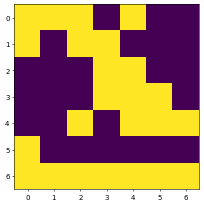

In [24]:
env.render()

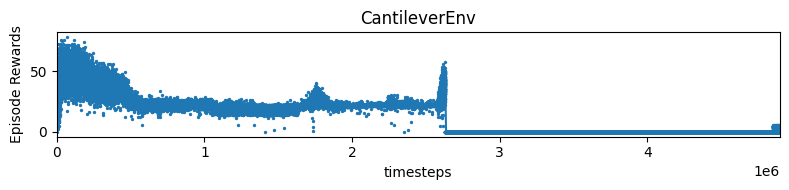

In [25]:
results_plotter.plot_results([log_dir], ts, results_plotter.X_TIMESTEPS, "CantileverEnv")

In [26]:
obs=env.reset()[0]

In [27]:
# Load the agent
model_best = PPO.load(log_dir + "best_model.zip",env=env)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.render_mode to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.render_mode` for environment variables or `env.get_wrapper_attr('render_mode')` that will search the reminding wrappers.
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/stable_baselines3/common/vec_env/base_vec_env.py:77: UserWarning: The `render_mode` attribute is not defined in your environment. It will be set to None.
  warnings.warn("The `render_mode` attribute is not defined in your environment. It will be set to None.")


In [28]:
i=0
while i<1000:
    action, _states = model_best.predict(obs)
    
    obs, rewards, dones, _,info = env.step(int(action))
#     print(env.tmp, env.const)
    if dones:
        break
    i+=1

In [29]:
i

49


Final Cantilever beam design:


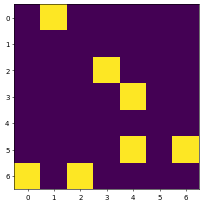

In [30]:
env.render()

In [31]:
# TODO - https://www.sciencedirect.com/science/article/pii/S0264127522002933

# 6 by 6 grid
# different reward 3 
# training ~1.5 hr

# illegal moves reward = -1, terminate ? 

# CNN
# randomize loads 
# utilize symmetry
# reward at the end of episode
# action - remove elements not add 
# refinement 6x6 -> 12x12
# load two elements in inference - test generalizability
# input stress field instead of density field 
# test different RL algorithms 

In [32]:
import random

In [33]:
for j in range(10):
    i=0
    obs=env.reset()
    while i<16*0.68753125:
        action = random.randint(0, 15)

        env.args = get_args(*mbb_beam(rd=env.rd))

        env.M.action_space_(action, env.x)   
        env.tmp, env.const = fast_stopt(env.args, env.x)
        
        i+=1
    print(env.tmp, env.const)    

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.rd to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.rd` for environment variables or `env.get_wrapper_attr('rd')` that will search the reminding wrappers.
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.M to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.M` for environment variables or `env.get_wrapper_attr('M')` that will search the reminding wrappers.
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.x to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.x` for

2730199864.8314376 0.16334897959183675
2777299389.393607 0.14294285714285715
2617662908.2641897 0.14294285714285715
2724378389.251207 0.18375510204081635
2575706859.5147777 0.14294285714285715
2729452673.8275003 0.18375510204081635
4296296140.41826 0.16334897959183675
4491241197.440759 0.16334897959183675
2740621926.334206 0.16334897959183675
5119724131.275006 0.18375510204081635


In [34]:
for j in range(10):
    i=0
    obs=env.reset()
    while i<9*0.68753125:
        action = random.randint(0, 8)

        env.args = get_args(*mbb_beam(rd=env.rd))

        env.M.action_space_(action, env.x)   
        env.tmp, env.const = fast_stopt(env.args, env.x)
        
        i+=1
    print(env.tmp, env.const)   

3764371508.0007544 0.08172448979591837
3791357134.4595637 0.08172448979591838
6046062437.245575 0.10213061224489797
3792378327.670762 0.06131836734693878
3628769143.0292106 0.12253673469387755
6085315775.568247 0.10213061224489797
3756020329.609011 0.10213061224489797
6071292918.065533 0.12253673469387756
6077617302.884968 0.08172448979591837
3755002236.0965323 0.10213061224489797
